In [1]:
import os 
import pandas as pd
import re
import matplotlib.pyplot as plt
import csv

In [2]:
from google.cloud import bigquery

In [3]:
from datetime import timedelta

In [4]:
project_id = 'your-project-here'

In [5]:
BigQuery_client = bigquery.Client(project=project_id)

In [6]:
# This is a practice query to ensure you can pull a short query from lcp-consortium
practice = '''SELECT * FROM `lcp-consortium.mimiciv_note.radiology` LIMIT 10;'''

In [7]:
# Put the short practice query into a dataframe
dfpractice = BigQuery_client.query(practice).to_dataframe()
dfpractice.head()

,note_id,subject_id,hadm_id,note_type,note_seq,charttime,storetime,text
0,14923562-RR-256,14923562,23365149,RR,256,2116-02-07 04:07:00,2116-02-07 10:28:00,EXAMINATION: CHEST (PORTABLE AP)\n\nINDICATIO...
1,14295224-RR-256,14295224,26322817,RR,256,2167-06-01 18:06:00,2167-06-01 19:27:00,EXAMINATION: CHEST (PORTABLE AP)\n\nINDICATIO...
2,10312715-RR-256,10312715,23111705,RR,256,2183-09-16 13:46:00,2183-09-16 14:35:00,INDICATION: ___ with injury to L ankle - stru...
3,15171624-RR-256,15171624,25142670,RR,256,2183-11-29 08:05:00,2183-11-29 10:13:00,REASON FOR EXAM: ___ man with chest radiograp...
4,10578325-RR-256,10578325,20206823,RR,256,2147-05-04 15:08:00,2147-05-04 15:53:00,EXAMINATION: CHEST PORT. LINE PLACEMENT\n\nIN...


In [8]:
### Code below works with all CTPAs identified ###

In [9]:
# Import the file of all CTPAs, including both positive and negative PE
AllCTPA = pd.read_csv("/AllCTPA.csv")

In [10]:
len(AllCTPA)

17417

In [11]:
# I want to pull in all XR images available from MIMIC-CXR
CXR = '''--CTE for dicom table
WITH dicom AS
(SELECT dicom, VIEWPOSITION
FROM `physionet-data.mimic_cxr.dicom_metadata_string`),

--CTE for record table
record AS
(SELECT study_id, dicom_id
FROM `physionet-data.mimic_cxr.record_list`),

--CTE for study table
study AS
(SELECT subject_id, study_id, study_datetime, path, text
FROM `physionet-data.mimic_cxr.study`)

SELECT * FROM study
LEFT JOIN record
ON study.study_id = record.study_id
LEFT JOIN dicom
ON record.dicom_id = dicom.dicom'''

In [12]:
CXR = BigQuery_client.query(CXR).to_dataframe()
CXR.head()

,subject_id,study_id,study_datetime,path,text,study_id_1,dicom_id,dicom,VIEWPOSITION
0,11604900,55592749,2118-01-28 11:17:07.546,files/p11/p11604900/s55592749.txt,FINAL REPORT\...,55592749,ca26a21d-a463ec18-769b3820-6a67408f-88f6d707,ca26a21d-a463ec18-769b3820-6a67408f-88f6d707,RAO
1,11604900,55592749,2118-01-28 11:17:07.546,files/p11/p11604900/s55592749.txt,FINAL REPORT\...,55592749,adecfaf9-19607119-492efcb4-893f689d-f3878f72,adecfaf9-19607119-492efcb4-893f689d-f3878f72,LAO
2,12749637,51366076,2193-11-29 15:55:50.781,files/p12/p12749637/s51366076.txt,WET READ: ___ ___ 4:48 PM\n 1. Retrocardiac ...,51366076,f5d4e935-ce59dfb8-7e648510-ac5196e8-14cb0997,f5d4e935-ce59dfb8-7e648510-ac5196e8-14cb0997,RAO
3,12749637,51366076,2193-11-29 15:55:50.781,files/p12/p12749637/s51366076.txt,WET READ: ___ ___ 4:48 PM\n 1. Retrocardiac ...,51366076,29c5aae9-6673f34e-dabe2bdd-57dcfc41-30f0620c,29c5aae9-6673f34e-dabe2bdd-57dcfc41-30f0620c,RAO
4,12749637,51366076,2193-11-29 15:55:50.781,files/p12/p12749637/s51366076.txt,WET READ: ___ ___ 4:48 PM\n 1. Retrocardiac ...,51366076,8dd012e1-61c6e46b-c634921d-c3a11d4e-2046d0e1,8dd012e1-61c6e46b-c634921d-c3a11d4e-2046d0e1,LAO


In [13]:
len(CXR)

377110

In [14]:
# How many unique values are there in study_id in the CXR dataframe?
unique_studyid = CXR['study_id'].nunique()
print("Number of unique study IDs:", unique_studyid)

Number of unique study IDs: 227835


In [15]:
# Merge the CXR dataframe with the dataframe containing all CTPAs
CXRallCTA = AllCTPA.merge(CXR, on='subject_id', how='left')
len(CXRallCTA)

122166

In [16]:
# Filter the dataframe down to only include rows where there is an associated CXR
CXRallCTA_notna = CXRallCTA.dropna(subset=['dicom'])
len(CXRallCTA_notna)

113523

In [17]:
# Make a copy to work with datetime
CXRtoallCTA = CXRallCTA_notna.copy()

In [18]:
# Ensure everything is in datetime format
CXRtoallCTA['charttime'] = pd.to_datetime(CXRtoallCTA['charttime'])
CXRtoallCTA['storetime'] = pd.to_datetime(CXRtoallCTA['storetime'])
CXRtoallCTA['study_datetime'] = pd.to_datetime(CXRtoallCTA['study_datetime'])

In [19]:
# Calculate time difference between CXR order time and CTA order time 
CXRtoallCTA['CXRtoCTA'] = CXRtoallCTA['study_datetime'] - CXRtoallCTA['charttime']

In [22]:
# Create a new column that is the time difference in hours
CXRtoallCTA['time_elapsed_hours'] = CXRtoallCTA['CXRtoCTA'].dt.total_seconds()/3600

In [25]:
# Create a new column that evalutes to true if the time difference is within 24 hours
CXRtoallCTA['within_24'] = abs(CXRtoallCTA['time_elapsed_hours']) <= 24

In [26]:
# Create a new column that evalutes to true if the time difference is 24 hours before and up to 48 hours after
CXRtoallCTA['and_48_hours'] = (CXRtoallCTA['time_elapsed_hours'] >= -24) & (CXRtoallCTA['time_elapsed_hours'] <= 48)

In [28]:
# How many CXRs are there within 24 hours? 
CXR_within_24h = CXRtoallCTA['within_24'].sum()
print("Number of True values in 'within_24' column:", CXR_within_24h)

Number of True values in 'within_24' column: 7175


In [29]:
# How many CXRs are there within -24 hours and +48 hours?
CXR_within_48h = CXRtoallCTA['and_48_hours'].sum()
print("Number of True values in 'and_48_hours' column:", CXR_within_48h)

Number of True values in 'and_48_hours' column: 8054


In [33]:
# Can we convert the amount of time between CXR to CTA to days so that we can see a histogram of the distribution
CXRtoallCTA['time_elapsed_days'] = CXRtoallCTA['CXRtoCTA'].dt.days

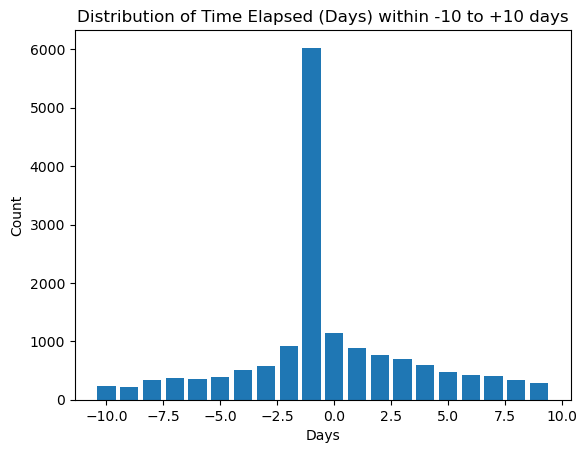

In [34]:
# Define the range for x-axis ticks (-10 to +10 days)
x_ticks_range = range(-10, 10)

# Count the occurrences of each day within the specified range
day_counts = CXRtoallCTA['time_elapsed_days'].value_counts().reindex(x_ticks_range, fill_value=0)

# Plotting the bar graph
plt.bar(day_counts.index, day_counts.values)

# Adding labels and title
plt.xlabel('Days')
plt.ylabel('Count')
plt.title('Distribution of Time Elapsed (Days) within -10 to +10 days')

# Display the plot
plt.show()

In [35]:
## Code below here deals with CTAs that are POSITIVE for PE only

In [36]:
# Import the file of positive CTPAs only
PosCTA = pd.read_csv("/PosPE.csv")

In [38]:
len(PosCTA)

1531

In [37]:
CXRposCTA = PosCTA.merge(CXR, on='subject_id', how='left')

In [39]:
# Ensure everything is in datetime format
CXRposCTA['charttime'] = pd.to_datetime(CXRposCTA['charttime'])
CXRposCTA['storetime'] = pd.to_datetime(CXRposCTA['storetime'])
CXRposCTA['study_datetime'] = pd.to_datetime(CXRposCTA['study_datetime'])

In [40]:
# Calculate time difference between CXR order time and CTA order time 
CXRposCTA['CXRtoCTA'] = CXRposCTA['study_datetime'] - CXRposCTA['charttime']

In [41]:
# Create a new column that is the time difference in hours
CXRposCTA['time_elapsed_hours'] = CXRposCTA['CXRtoCTA'].dt.total_seconds()/3600

In [42]:
# Create a new column that evalutes to true if the time difference is within 24 hours
CXRposCTA['within_24'] = abs(CXRposCTA['time_elapsed_hours']) <= 24

In [43]:
# Create a new column that evalutes to true if the time difference is 24 hours before and up to 48 hours after
CXRposCTA['and_48_hours'] = (CXRposCTA['time_elapsed_hours'] >= -24) & (CXRposCTA['time_elapsed_hours'] <= 48)

In [45]:
# Create a dataframe that only includes CXRs that are within 24 hours of negative CTAs
CXRposCTA24 = CXRposCTA[CXRposCTA['within_24']]

In [46]:
len(CXRposCTA24)

668

In [50]:
# Filter down the dataframe further to only include viewposition AP or PA
CXRposCTA24view = CXRposCTA24[(CXRposCTA24['VIEWPOSITION'] == 'AP') | (CXRposCTA24['VIEWPOSITION'] == 'PA')]

In [51]:
len(CXRposCTA24view)

471

In [57]:
# Export for modeling
CXRposCTA24view.to_csv('/CXRpos24.csv', index=False)

In [54]:
# How many unique values are there in study_id?
pos24unique = CXRposCTA24view['study_id'].nunique()
print("Number of unique study IDs:", pos24unique)

Number of unique study IDs: 427


In [47]:
# Create a dataframe that only includes CXRs that are within -24h and +48h of negative CTAs
CXRposCTA48 = CXRposCTA[CXRposCTA['and_48_hours']]

In [48]:
len(CXRposCTA48)

761

In [52]:
# Filter down the dataframe further to only include viewposition AP or PA
CXRposCTA48view = CXRposCTA48[(CXRposCTA48['VIEWPOSITION'] == 'AP') | (CXRposCTA48['VIEWPOSITION'] == 'PA')]

In [53]:
len(CXRposCTA48view)

560

In [58]:
# Export for modeling
CXRposCTA48view.to_csv('/CXRpos48.csv', index=False)

In [56]:
# How many unique values are there in study_id?
pos48unique = CXRposCTA48view['study_id'].nunique()
print("Number of unique study IDs:", pos48unique)

Number of unique study IDs: 510


In [59]:
## Code below here deals with CTAs that are NEGATIVE for PE only

In [60]:
# Import the file of negative CTPAs only
NegCTA = pd.read_csv("/NegPE.csv")

In [69]:
len(NegCTA)

15886

In [61]:
CXRnegCTA = NegCTA.merge(CXR, on='subject_id', how='left')

In [62]:
# Ensure everything is in datetime format
CXRnegCTA['charttime'] = pd.to_datetime(CXRnegCTA['charttime'])
CXRnegCTA['storetime'] = pd.to_datetime(CXRnegCTA['storetime'])
CXRnegCTA['study_datetime'] = pd.to_datetime(CXRnegCTA['study_datetime'])

In [63]:
# Calculate time difference between CXR order time and CTA order time 
CXRnegCTA['CXRtoCTA'] = CXRnegCTA['study_datetime'] - CXRnegCTA['charttime']

In [64]:
# Create a new column that is the time difference in hours
CXRnegCTA['time_elapsed_hours'] = CXRnegCTA['CXRtoCTA'].dt.total_seconds()/3600

In [65]:
# Create a new column that evalutes to true if the time difference is within 24 hours
CXRnegCTA['within_24'] = abs(CXRnegCTA['time_elapsed_hours']) <= 24

In [66]:
# Create a new column that evalutes to true if the time difference is 24 hours before and up to 48 hours after
CXRnegCTA['and_48_hours'] = (CXRnegCTA['time_elapsed_hours'] >= -24) & (CXRnegCTA['time_elapsed_hours'] <= 48)

In [67]:
# Create a dataframe that only includes CXRs that are within 24 hours of negative CTAs
CXRnegCTA24 = CXRnegCTA[CXRnegCTA['within_24']]

In [68]:
len(CXRnegCTA24)

6507

In [70]:
# Filter down the dataframe further to only include viewposition AP or PA
CXRnegCTA24view = CXRnegCTA24[(CXRnegCTA24['VIEWPOSITION'] == 'AP') | (CXRnegCTA24['VIEWPOSITION'] == 'PA')]

In [71]:
len(CXRnegCTA24view)

4280

In [72]:
# Export for modeling
CXRnegCTA24view.to_csv('/CXRneg24.csv', index=False)

In [73]:
# How many unique values are there in study_id?
neg24unique = CXRnegCTA24view['study_id'].nunique()
print("Number of unique study IDs:", neg24unique)

Number of unique study IDs: 3890


In [74]:
# Create a dataframe that only includes CXRs that are within -24h and +48h of negative CTAs
CXRnegCTA48 = CXRnegCTA[CXRnegCTA['and_48_hours']]

In [75]:
len(CXRnegCTA48)

7293

In [76]:
# Filter each dataframe down to only include AP or PA CXRs
CXRnegCTA48view = CXRnegCTA48[(CXRnegCTA48['VIEWPOSITION'] == 'AP') | (CXRnegCTA48['VIEWPOSITION'] == 'PA')]

In [77]:
len(CXRnegCTA48view)

4988

In [78]:
# Export for modeling
CXRnegCTA48view.to_csv('/CXRneg48.csv', index=False)

In [79]:
# How many unique values are there in study_id?
neg48unique = CXRnegCTA48view['study_id'].nunique()
print("Number of unique study IDs:", neg48unique)

Number of unique study IDs: 4521
